# Byte-Pair Encoding Skip-Gram Embeddings

> **Note**: This notebook is compatible with both Google Colab and local Jupyter environments. Colab-specific sections are clearly marked.

This notebook explores subword-level representation learning in the biomedical domain using Byte Pair Encoding (BPE) and a Skip-Gram Word2Vec model trained on PubMed abstracts. It begins with custom preprocessing tailored to medical text, followed by BPE tokenization to capture meaningful subword patterns common in biomedical terminology.

To examine the quality of the learned embeddings, the notebook includes:
- UMAP visualizations of the subword embedding space
- Word similarity lookups to explore local subword relationships
- Word analogies to test semantic composition
- A histogram of cosine similarities to assess distribution and density

The results highlight how BPE-based embeddings organize biomedical subwords semantically, offering a more flexible foundation for downstream NLP tasks such as classification, clustering, and entity recognition.

In [ ]:
!pip install nltk tokenizers gensim tqdm swifter umap-learn --no-cache-dir

In [2]:
import sys
import os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

    project_path = '/content/drive/MyDrive/NLP_Projects/Week_3/word-embeddings-playground'
    if os.path.exists(project_path):
        os.chdir(project_path)
        print(f"Changed working directory to: {project_path}")
    else:
        raise FileNotFoundError(f"Project path not found: {project_path}")
else:
    print("Not running in Colab — skipping Drive mount.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Changed working directory to: /content/drive/MyDrive/NLP_Projects/Week_3/word-embeddings-playground


## Import Libraries

In [46]:
# import libraries
import pandas as pd
import numpy as np

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

from gensim.models import Word2Vec
import swifter

from tqdm import tqdm

from gensim.models import Word2Vec, KeyedVectors

from umap import UMAP

import csv

from sklearn.metrics.pairwise import cosine_similarity

import random
random.seed(42)
np.random.seed(42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [47]:
# load stop words from NLTK
stop_words = set(stopwords.words('english'))

## Load Data

## Load and Preprocess PubMed Abstracts

This cell loads the PubMed abstracts dataset from a CSV file and drops any missing values in the `Abstract` column to retain only valid text entries.

- **File path:** `./data/pubmed_abstracts.csv`
- **Column used:** `Abstract`
- **Missing values:** Removed using `dropna()`

In [48]:
data = pd.read_csv('./data/pubmed_abstracts.csv')
data = data['Abstract'].dropna()

## Custom Text Preprocessing for BPE Tokenization

This section applies domain-specific preprocessing to prepare biomedical abstracts for Byte Pair Encoding (BPE). The cleaning pipeline is similar to the one used in the Skip-Gram workflow, with one key difference: **lemmatization is skipped** to preserve full word forms for subword segmentation.

#### Preprocessing steps:
- Converts text to lowercase
- Replaces numeric patterns with the `<NUM>` placeholder while preserving decimal points and slashes
- Tokenizes using a custom regular expression tokenizer built for biomedical formats
- Removes stop words and most punctuation (except `.` and `/`)
- Joins the cleaned tokens back into a string for subword encoding

The result is a corpus optimized for training a subword tokenizer, preserving important domain-specific structures while minimizing noise.

In [49]:
custom_tokenizer = RegexpTokenizer(r'[a-zA-Z\d<NUM>./]+(?:-[a-zA-Z\d<NUM>./]+)*|<NUM>\.<NUM>/<NUM>\.<NUM>|<NUM>\.<NUM>/<NUM>|<NUM>/<NUM>\.<NUM>|<NUM>/<NUM>|<NUM>\.<NUM>|<NUM>|\w+|')

In [50]:
def replace_numbers(text):
  """
  Replaces standalone numbers and specific numeric patterns in a text string with placeholders.

  - Replaces decimal points between digits (e.g., "6.8") with '<DOT>' temporarily.
  - Replaces slashes between digits (e.g., "120/80") with '<SLASH>' temporarily.
  - Replaces all standalone whole numbers with the token '<NUM>'.
  - Restores the decimal points and slashes after substitution.

  Args:
      text (str): Input text to process.

  Returns:
      str: Text with numeric values standardized using the '<NUM>' placeholder.
  """
  text = re.sub(r'(?<=\d)\.(?=\d)', r'<DOT>', text)
  text = re.sub(r'(?<=\d)/(?=\d)', r'<SLASH>', text)
  text = re.sub(r'\b\d+\b', r'<NUM>', text)
  text = text.replace('<DOT>', '.').replace('<SLASH>', '/')
  return text

In [51]:
def clean_text(text):
  """
  Cleans biomedical text for subword tokenization using custom rules.

  Steps:
  1. Lowercases the text.
  2. Replaces numeric patterns with the <NUM> placeholder while preserving structure.
  3. Tokenizes using a custom regular expression tokenizer designed for biomedical terms.
  4. Removes stop words.
  5. Removes most punctuation, except periods and slashes.

  Args:
      text (str): Raw input string to clean.

  Returns:
      List[str]: List of cleaned tokens suitable for BPE or other subword models.
  """
  text = text.lower()
  text = replace_numbers(text)
  tokens = custom_tokenizer.tokenize(text)
  tokens = [t for t in tokens if t not in stop_words]
  tokens = [t for t in tokens if t not in string.punctuation or t in ('.', '/')]
  return tokens

In [52]:
cleaned_text = data.swifter.apply(lambda x: ' '.join(clean_text(x)))

Pandas Apply:   0%|          | 0/9981 [00:00<?, ?it/s]

In [94]:
cleaned_text

,0
0,. trump decision stop funding world health org...
1,13th conference european hidradenitis suppurat...
2,19th century scope blood transfusion significa...
3,21st century cures act many health systems rel...
4,21st international vasculitis workshop held ba...
...,...
9976,zigbee-based indoor localization system design...
9977,zika virus zikv flavivirus transmitted primari...
9978,zilcha-mano see record <NUM>-<NUM>-<NUM> provi...
9979,zinc vital <NUM> enzymes major metabolic pathw...


In [63]:
cleaned_text = cleaned_text.sort_values(by = 0)
cleaned_text.to_csv('./data/bpe_skipgram/cleaned_abstracts.csv', index = False, header = False)

## Train Byte Pair Encoding (BPE) Tokenizer

This section trains a BPE tokenizer on the cleaned biomedical abstracts using the `tokenizers` library.

- **Tokenizer type**: Byte Pair Encoding (BPE)
- **Pre-tokenization**: Whitespace-based
- **Vocabulary size**: 10,000
- **Special tokens**: `<UNK>`, `<NUM>`, `<PAD>`

The tokenizer is trained on the cleaned abstracts and saved as a JSON file for reuse.

In [64]:
tokenizer = Tokenizer(BPE(unk_token = '<UNK>'))
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(vocab_size = 10_000, special_tokens = ['<UNK>', '<NUM>', '<PAD>'])

In [65]:
tokenizer.train(['./data/bpe_skipgram/cleaned_abstracts.csv'], trainer)

In [66]:
tokenizer.save('./data/bpe_skipgram/bpe_tokenizer.json')

## Apply Trained BPE Tokenizer

This section loads the saved BPE tokenizer and applies it to the cleaned biomedical abstracts.

- **Input**: Cleaned abstracts from CSV (`cleaned_abstracts.csv`)
- **Tokenizer**: Loaded from the saved JSON file
- **Output**: Each abstract is encoded into a list of BPE subword tokens

The result is a tokenized corpus ready for training subword-based embedding models.

In [67]:
cleaned_text = pd.read_csv('./data/bpe_skipgram/cleaned_abstracts.csv', header = None)
tokenizer = Tokenizer.from_file('./data/bpe_skipgram/bpe_tokenizer.json')

In [68]:
tokenized_text = cleaned_text.squeeze().swifter.apply(lambda x: tokenizer.encode(x).tokens).tolist()

Pandas Apply:   0%|          | 0/9981 [00:00<?, ?it/s]

## Train Skip-Gram Model on BPE-Tokenized Text

A Word2Vec Skip-Gram model is trained on the BPE-tokenized abstracts to learn subword-level embeddings.

- **Embedding size**: 200  
- **Window size**: 5  
- **Minimum frequency**: 20  
- **Training epochs**: 10  
- **Architecture**: Skip-Gram (`sg=1`)

The trained model and its word vectors are saved for downstream evaluation and comparison to the word-level Skip-Gram model.

In [69]:
skipgram_model = Word2Vec(
    vector_size = 200,
    window = 5,
    sg = 1,
    min_count = 20,
    workers = 4,
    seed = 56
)

In [70]:
skipgram_model.build_vocab(tokenized_text)

In [71]:
skipgram_model.train(tokenized_text, total_examples = skipgram_model.corpus_count, epochs = 10)

(18036115, 21218620)

In [72]:
skipgram_model.save('./results/bpe_skipgram/bpe_model.model')

embeddings = skipgram_model.wv
embeddings.save('./results/bpe_skipgram/bpe_embeddings.embeddings')

## Visualizing BPE Embeddings with UMAP

### Full Vocabulary Projection

This plot displays a 2D UMAP projection of all subword embeddings learned from the BPE-tokenized corpus.

- **Input**: All BPE tokens from the trained Skip-Gram model  
- **UMAP settings**: `n_neighbors=15`, `min_dist=0.1`, `metric='cosine'`
- **Plot**: A dense scatter of all embeddings with a subset of tokens labeled for interpretability

This view provides a high-level look at how the BPE subword space is organized.

In [73]:
words = list(embeddings.index_to_key)
vectors = embeddings[words]

In [74]:
reducer = UMAP(n_neighbors = 15, min_dist = 0.1, metric = 'cosine', random_state = 42)
embeddings_2d = reducer.fit_transform(vectors)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


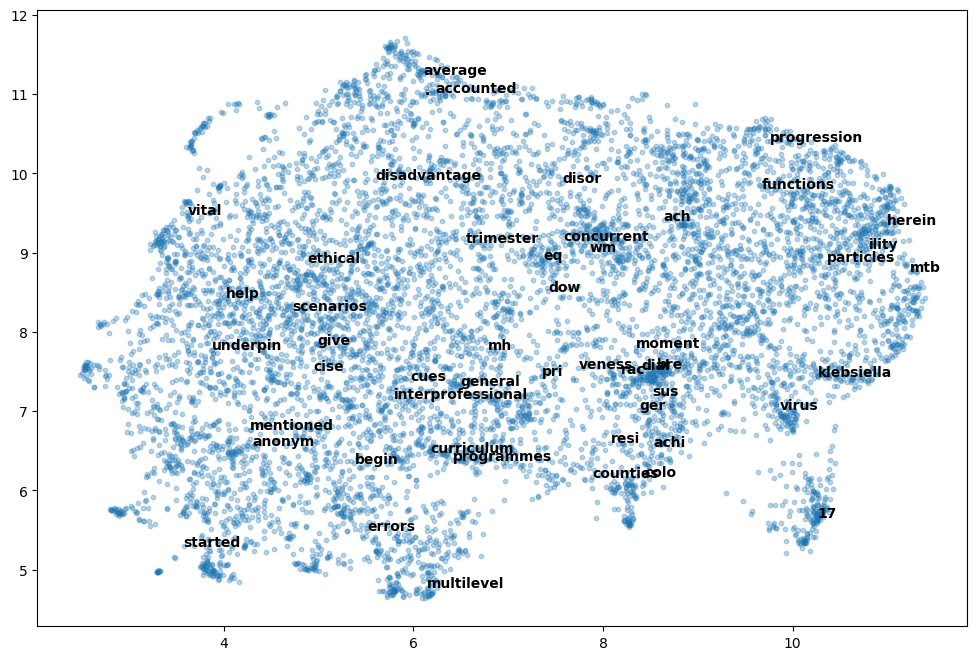

In [75]:
plt.figure(figsize = (12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha = 0.3, s = 10)

for i in range(0, len(words), max(1, len(words) // 50)):
  plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], words[i], fontsize = 10, weight = 'bold')

plt.savefig('./results/bpe_skipgram/umap_full_vocab.png', dpi = 300, bbox_inches = 'tight')

plt.show()

### Frequent Subword Projection

This plot focuses on the top 3,000 most frequent BPE tokens in the corpus, providing a clearer and less cluttered view of the embedding space.

- **Input**: Most frequent subword units from the BPE tokenizer
- **UMAP settings**: `n_neighbors=15`, `min_dist=0.1`, `metric='cosine'`
- **Plot**: Subset of embeddings visualized with the top 50 tokens labeled for easier interpretation

This focused view helps highlight patterns among commonly used biomedical subwords.

In [76]:
frequent_words = words[:3000]
frequent_vectors = embeddings[frequent_words]

In [77]:
reducer = UMAP(n_neighbors = 15, min_dist = 0.1, metric = 'cosine', random_state = 42)
embeddings_2d = reducer.fit_transform(frequent_vectors)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


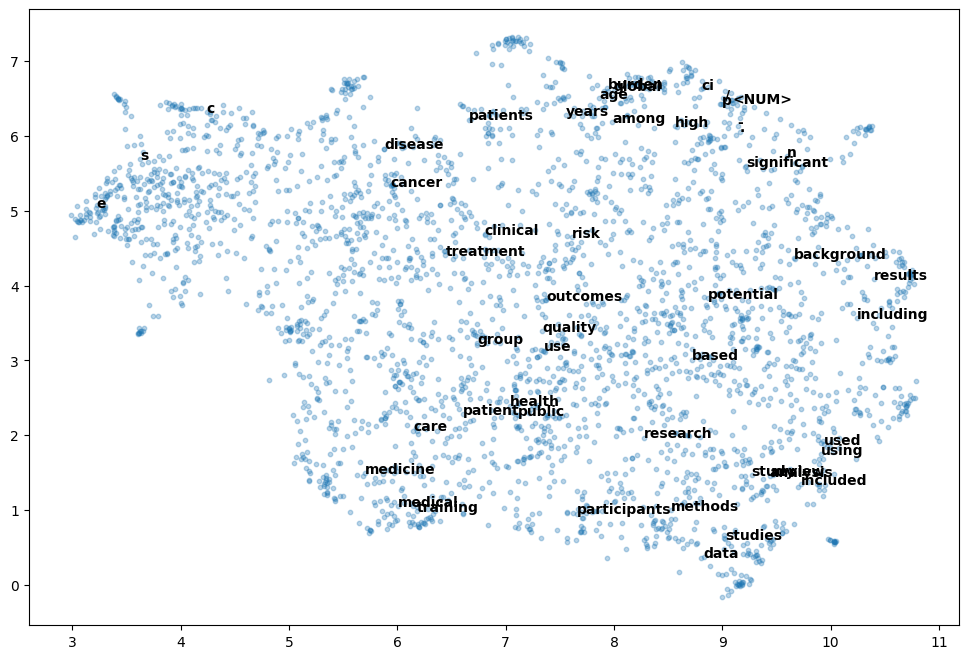

In [78]:
plt.figure(figsize = (12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha = 0.3, s = 10)

for i in range(0, 50):
  plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], words[i], fontsize = 10, weight = 'bold')

plt.savefig('./results/bpe_skipgram/umap_common_words.png', dpi = 300, bbox_inches = 'tight')

plt.show()

## Explore Similar Tokens Using Trained Embeddings

This utility prints the top-N most similar tokens to a given input word based on cosine similarity from the trained Skip-Gram embeddings.

- **Function:** `get_n_similar_words(word, embeddings, n)`
- **Similarity metric:** Cosine distance
- **Examples shown:**  
  - "diabetes"  
  - "cancer"  
  - "disease"  
  - "analysis"  
  - "cardiovascular"

These results help qualitatively evaluate how well the model captures semantic relationships in the biomedical domain.

In [79]:
def get_n_similar_words(word, embeddings, n):
  """
  Prints the top-N most similar words to a given word based on cosine similarity.

  Args:
      word (str): The target word to find similar words for.
      embeddings (gensim KeyedVectors): Trained word embedding model (e.g., Word2Vec.wv).
      n (int): Number of most similar words to retrieve.

  Returns:
      None: Prints the similar words and their similarity scores to the console.
  """
  print(f'{n} Similar Words to {word}:')
  print('-----------------------------')
  similar_words = embeddings.most_similar(word, topn = n)
  for w, s in similar_words:
    print(f'{w}: {s}')

In [80]:
get_n_similar_words('diabetes', embeddings, 10)

10 Similar Words to diabetes:
-----------------------------
mellitus: 0.8008227348327637
t2d: 0.656130313873291
hypertension: 0.6073864698410034
t2dm: 0.6026310920715332
t1d: 0.6011666059494019
ckd: 0.5838865637779236
t1dm: 0.5752618908882141
gdm: 0.5384544730186462
ascvd: 0.5293023586273193
glycemic: 0.5267386436462402


In [81]:
get_n_similar_words('cancer', embeddings, 10)

10 Similar Words to cancer:
-----------------------------
breast: 0.6722633242607117
cancers: 0.6700031757354736
prostate: 0.6072020530700684
squamous: 0.5586369633674622
melanoma: 0.5534393191337585
ovarian: 0.5425386428833008
malignancies: 0.5284885764122009
metastatic: 0.5270430445671082
pancreatic: 0.5229208469390869
tnbc: 0.5156349539756775


In [82]:
get_n_similar_words('disease', embeddings, 10)

10 Similar Words to disease:
-----------------------------
diseases: 0.6066218614578247
dementias: 0.5561509132385254
ild: 0.5340756177902222
autoimmune: 0.498820036649704
pancreatitis: 0.49455538392066956
gout: 0.4930781424045563
atheros: 0.4838750660419464
alzheimer: 0.48253965377807617
hfpg: 0.4769004285335541
aeti: 0.4618009924888611


In [83]:
get_n_similar_words('analysis', embeddings, 10)

10 Similar Words to analysis:
-----------------------------
analyses: 0.6793650388717651
stata: 0.5206653475761414
analysed: 0.49197953939437866
nma: 0.4915669858455658
wallis: 0.48909991979599
atlas: 0.47388985753059387
kruskal: 0.4723207652568817
deductive: 0.45947641134262085
convergent: 0.45463627576828003
inductive: 0.45320770144462585


In [84]:
get_n_similar_words('cardiovascular', embeddings, 10)

10 Similar Words to cardiovascular:
-----------------------------
atherosclerotic: 0.6301570534706116
ascvd: 0.5930964946746826
cardiometabolic: 0.5623195171356201
cvd: 0.5469959378242493
coronary: 0.47974079847335815
diabetes: 0.4707332253456116
cardio: 0.46882325410842896
ncds: 0.46006080508232117
multimorbidity: 0.4551314115524292
cardiac: 0.4534582495689392


In [85]:
with open('./results/bpe_skipgram/similar_words_output.csv', 'w', newline = '') as f:
    writer = csv.writer(f)
    writer.writerow(['Target Word', 'Similar Word', 'Similarity'])
    for word in ['diabetes', 'cancer', 'disease', 'analysis', 'cardiovascular']:
        similar_words = embeddings.most_similar(word, topn = 10)
        for w, s in similar_words:
            writer.writerow([word, w, round(s, 4)])

## Cosine Similarity Distribution Between Token Embeddings

This plot shows the distribution of pairwise cosine similarities between all token embeddings in the vocabulary.

- **Input**: Cosine similarity matrix for all token vectors
- **Processing**: Only upper triangle values (excluding diagonal) are used to avoid duplicates
- **Plot**: Histogram of similarity scores

This helps evaluate how tightly clustered or dispersed the learned embedding space is.

In [86]:
similarities = cosine_similarity(vectors, vectors)

upper_i, upper_j = np.triu_indices(similarities.shape[0], k = 1)
similarities = similarities[upper_i, upper_j]

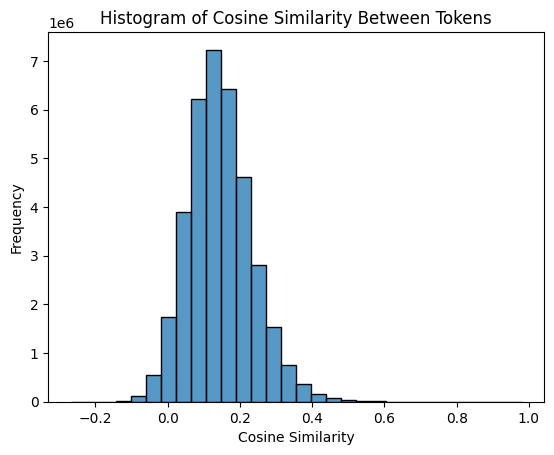

In [87]:
sns.histplot(similarities, bins = 30, kde = False)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine Similarity Between Tokens')
plt.savefig('./results/bpe_skipgram/cosine_similarity_histogram.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Word Analogy Exploration

This section uses vector arithmetic to explore analogies in the embedding space using the `most_similar` method from `gensim`.

- **Function:** `get_analogy(positives, negatives, embeddings, n)`
- **Purpose:** Answers analogies of the form:
  > *A is to B as C is to ?*

### Examples:
- heart → cardiovascular :: lung → ?
- bacteria → antibiotic :: virus → ?
- psychiatry → mental :: cardiology → ?
- cancer → oncology :: pneumonia → ?

These examples demonstrate how well the model captures abstract semantic and domain-specific relationships in biomedical language.

In [88]:
def get_analogy(positives, negatives, embeddings, n):
  """
  Solves word analogies using vector arithmetic in the embedding space.

  Example: If negatives = ['diabetes'], positives = ['insulin', 'asthma'],
  the function answers: "diabetes is to insulin as asthma is to ?"

  Args:
      positives (List[str]): Words to add in the analogy (e.g., ['insulin', 'asthma']).
      negatives (List[str]): Word(s) to subtract in the analogy (e.g., ['diabetes']).
      embeddings (gensim KeyedVectors): Trained word embedding model (e.g., Word2Vec.wv).
      n (int): Number of most similar words to return.

  Returns:
      None: Prints the analogy result and top-n most similar words with similarity scores.
  """
  print(f'{negatives[0]} is to {positives[0]} as {positives[1]} is to:')
  print('---------------------------------------------------')
  results = embeddings.most_similar(positive = positives, negative = negatives, topn = n)
  for w, s in results:
    print(f'{w}: {s}')

In [89]:
get_analogy(positives = ['cardiovascular', 'lung'], negatives = ['heart'], embeddings = embeddings, n = 5)

heart is to cardiovascular as lung is to:
---------------------------------------------------
cancers: 0.43110910058021545
bladder: 0.42551228404045105
oncologic: 0.41899821162223816
cancer: 0.4157775044441223
pancreatic: 0.4129124879837036


In [90]:
get_analogy(positives = ['antibiotic', 'virus'], negatives = ['bacteria'], embeddings = embeddings, n = 5)

bacteria is to antibiotic as virus is to:
---------------------------------------------------
prophylaxis: 0.4757481515407562
rsv: 0.4107387661933899
antiviral: 0.40942123532295227
pylori: 0.4041212201118469
antibiotics: 0.4039280414581299


In [91]:
get_analogy(positives = ['mental', 'cardiology'], negatives = ['psychiatry'], embeddings = embeddings, n = 5)

psychiatry is to mental as cardiology is to:
---------------------------------------------------
hrqol: 0.3986181914806366
cardiovascular: 0.3940327763557434
heart: 0.35621267557144165
coronary: 0.35179445147514343
coaching: 0.34516793489456177


In [92]:
get_analogy(positives = ['oncology', 'pneumonia'], negatives = ['cancer'], embeddings = embeddings, n = 5)

cancer is to oncology as pneumonia is to:
---------------------------------------------------
bronch: 0.440964937210083
urinary: 0.4360135793685913
throat: 0.42520672082901
septic: 0.4156855642795563
staphylococcus: 0.41092076897621155


In [93]:
analogy_queries = [
    (['cardiovascular', 'lung'], ['heart']),
    (['antibiotic', 'virus'], ['bacteria']),
    (['mental', 'cardiology'], ['psychiatry']),
    (['oncology', 'pneumonia'], ['cancer']),
]

with open('./results/bpe_skipgram/analogy_results.csv', 'w', newline = '') as f:
    writer = csv.writer(f)
    writer.writerow(['Analogy', 'Predicted Word', 'Similarity'])

    for positives, negatives in analogy_queries:
        analogy_str = f"{negatives[0]} is to {positives[0]} as {positives[1]} is to"
        results = embeddings.most_similar(positive = positives, negative = negatives, topn = 5)
        for w, s in results:
            writer.writerow([analogy_str, w, round(s, 4)])